In [1]:
import os

from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import get_stats, read_pickled_object

In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 4

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))

X = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)['mean'].values.ravel()

# this is only available after running script 01 in notebook C
y_joint = pd.read_csv(os.path.join(data_path, 'processed',  'metastatic_potential_joint.csv'), index_col = 0)
y_proteomics = pd.read_csv(os.path.join(data_path, 'processed',  'metastatic_potential_protein.csv'), index_col = 0)


When iterating through sample sizes, we will keep the test dataset size the same (maximum amount -- 20% of the full dataset). This is to ensure metric stability. 

We also subset N times per sample size to ensure stability.

In [4]:
# set up manual fold params
n_splits = 10

fold_size = X.shape[0] // n_splits
train_samples_per_fold = int(np.round(X.shape[0] * ((100 - n_splits)/100)))

# prepare sample sizes
sample_sizes = np.arange(0.1,1.1, 0.1)

n_samples_iter = [int(np.round(train_samples_per_fold*sample_size)) for sample_size in sample_sizes]
if y_joint.shape[0] not in n_samples_iter:
    n_samples_iter.append(y_joint.shape[0]) # ensure the actualy join omics sample size is included
    n_samples_iter = sorted(n_samples_iter)
    
if y_proteomics.shape[0] not in n_samples_iter:
    n_samples_iter.append(y_proteomics.shape[0]) # ensure the actualy join omics sample size is included
    n_samples_iter = sorted(n_samples_iter)

# subsets per sample size
n_subsets = 100

In [17]:
res = pd.DataFrame(columns = ['fold', 'train_sample_size', 
                             'train_corr', 'test_corr', 'train_mse', 'test_mse'])

np.random.seed(random_state)
for k in range(n_splits):
    print(k)
    # manually get splits in order to ensure the are the same size across all folds
    shuffled_index = np.random.permutation(np.arange(X.shape[0]))
    train_idx = shuffled_index[:train_samples_per_fold]
    test_idx = shuffled_index[train_samples_per_fold:]
    
    X_train_full, X_test = X[train_idx], X[test_idx]
    y_train_full, y_test = y[train_idx], y[test_idx]
    
    for n_samples in n_samples_iter:
        if n_samples < train_samples_per_fold:
            for i in range(n_subsets):
                subset_idx = np.random.choice(train_samples_per_fold, n_samples, replace=False)
                X_train = X_train_full[subset_idx, :]
                y_train = y_train_full[subset_idx]

                train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train, y_test, X_train, X_test)

                res.loc[res.shape[0],:] = [k, n_samples, train_corr, test_corr, train_mse, test_mse]
        else:
            train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train_full, y_test, X_train_full, X_test)
            res.loc[res.shape[0],:] = [k, n_samples, train_corr, test_corr, train_mse, test_mse]
            
    res.to_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics.csv'))
            
            
            

In [5]:
res = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics.csv'), index_col = 0)

# just visualize the equal interval samples
res = res[~res.train_sample_size.isin([y_joint.shape[0], y_proteomics.shape[0]])]

<Axes: xlabel='train_sample_size', ylabel='test_corr'>

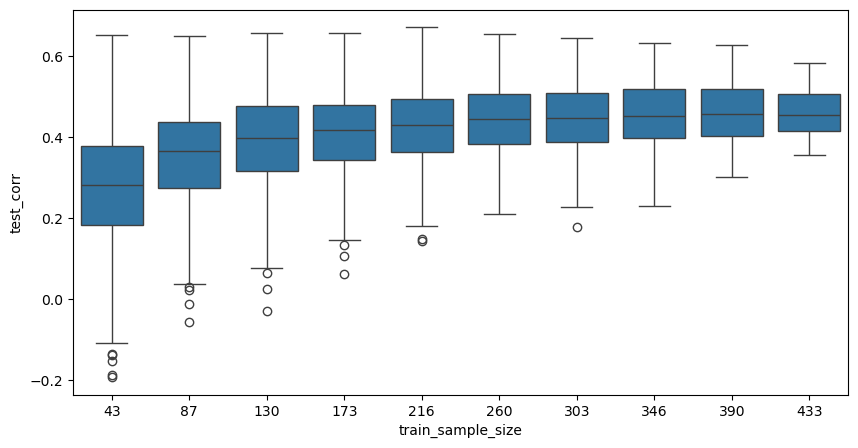

In [6]:
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(data = res, x = 'train_sample_size', y = 'test_corr')